# Лабораторная работа №2: Градиентный бустинг

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from gradient_boosting import GradientBoosting

## Загрузка и подготовка данных

In [3]:
# Загрузка данных
df = pd.read_csv('realtor-data.zip.csv')
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
df.head()

Размер датасета: (2226382, 12)

Первые 5 строк:


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [4]:
# Базовый анализ данных
print("\nИнформация о датасете:")
df.info()

print("\nПропущенные значения:")
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
print(missing_data)

print("\nОписание числовых признаков:")
df.describe()


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB

Пропущенные значения:
prev_sold_date    734297
house_size        568484
bath              511771
bed               481317
acre_lot          325589
street             10866
brokered_by         4533
price               1541
city                1407
zip_code             299
state                  8
dtype: int64

Описание числовых признаков:


,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,2.221849e+06,2.224841e+06,1.745065e+06,1.714611e+06,1.900793e+06,2.215516e+06,2.226083e+06,1.657898e+06
mean,5.293989e+04,5.241955e+05,3.275841e+00,2.496440e+00,1.522303e+01,1.012325e+06,5.218668e+04,2.714471e+03
std,3.064275e+04,2.138893e+06,1.567274e+00,1.652573e+00,7.628238e+02,5.837635e+05,2.895408e+04,8.081635e+05
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
25%,2.386100e+04,1.650000e+05,3.000000e+00,2.000000e+00,1.500000e-01,5.063128e+05,2.961700e+04,1.300000e+03
50%,5.288400e+04,3.250000e+05,3.000000e+00,2.000000e+00,2.600000e-01,1.012766e+06,4.838200e+04,1.760000e+03
75%,7.918300e+04,5.500000e+05,4.000000e+00,3.000000e+00,9.800000e-01,1.521173e+06,7.807000e+04,2.413000e+03
max,1.101420e+05,2.147484e+09,4.730000e+02,8.300000e+02,1.000000e+05,2.001357e+06,9.999900e+04,1.040400e+09


In [5]:
# Удаляем строки с пропущенными ценами (целевая переменная)
df_clean = df.dropna(subset=['price']).copy()

# Удаляем выбросы в ценах (очень дорогие дома могут исказить анализ)
price_q99 = df_clean['price'].quantile(0.99)
price_q01 = df_clean['price'].quantile(0.01)
df_clean = df_clean[(df_clean['price'] >= price_q01) & (df_clean['price'] <= price_q99)]

# Заполняем пропущенные значения
numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if col != 'price':
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

categorical_columns = df_clean.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

print(f"Размер очищенного датасета: {df_clean.shape}")
print(f"Удалено строк: {df.shape[0] - df_clean.shape[0]}")

Размер очищенного датасета: (2183325, 12)
Удалено строк: 43057


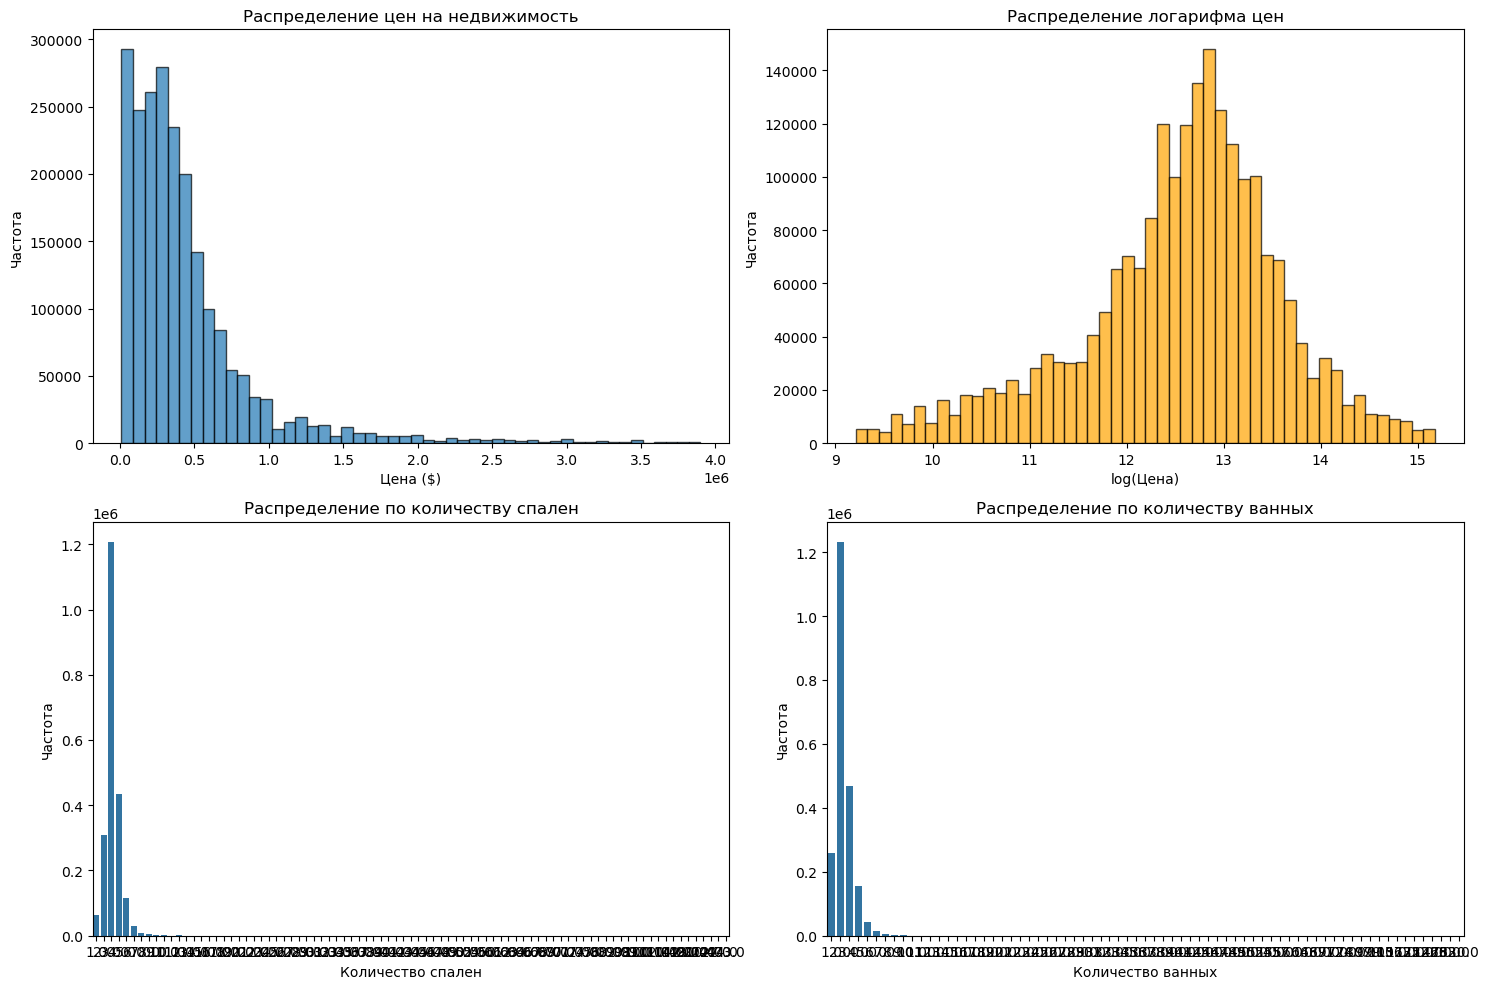

In [6]:
# Визуализация распределения целевой переменной (цена)
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(df_clean['price'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Распределение цен на недвижимость')
plt.xlabel('Цена ($)')
plt.ylabel('Частота')

plt.subplot(2, 2, 2)
plt.hist(np.log(df_clean['price']), bins=50, alpha=0.7, edgecolor='black', color='orange')
plt.title('Распределение логарифма цен')
plt.xlabel('log(Цена)')
plt.ylabel('Частота')

# Распределение по количеству спален и ванных
plt.subplot(2, 2, 3)
if 'bed' in df_clean.columns:
    sns.countplot(data=df_clean, x='bed')
    plt.title('Распределение по количеству спален')
    plt.xlabel('Количество спален')
    plt.ylabel('Частота')

plt.subplot(2, 2, 4)
if 'bath' in df_clean.columns:
    sns.countplot(data=df_clean, x='bath')
    plt.title('Распределение по количеству ванных')
    plt.xlabel('Количество ванных')
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

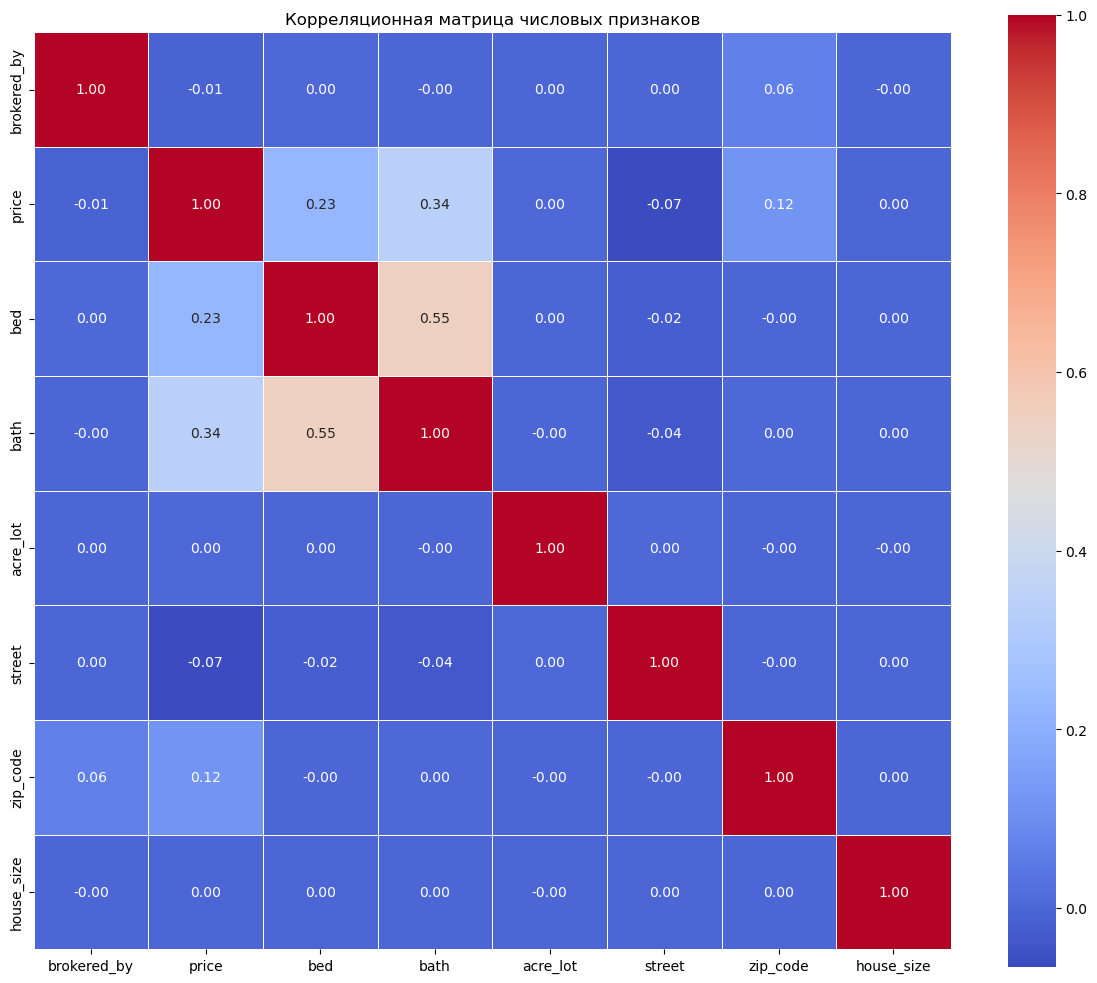


Признаки с наибольшей корреляцией с ценой:
price          1.000000
bath           0.338883
bed            0.229335
zip_code       0.118795
street         0.065537
brokered_by    0.011121
acre_lot       0.004420
house_size     0.000249
Name: price, dtype: float64


In [7]:
# Анализ взаимосвязей между признаками
# Выбираем только числовые признаки для корреляционной матрицы
numeric_features = df_clean.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 10))
correlation_matrix = numeric_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
            square=True, linewidths=0.5)
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()

# Показываем признаки с наибольшей корреляцией с ценой
price_correlation = correlation_matrix['price'].abs().sort_values(ascending=False)
print("\nПризнаки с наибольшей корреляцией с ценой:")
print(price_correlation.head(10))

In [8]:
# Подготовка признаков для модели
df_model = df_clean.head(40000).copy()

label_encoders = {}
for col in categorical_columns:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le

X = df_model.drop('price', axis=1)
y = df_model['price']

print(f"Количество признаков: {X.shape[1]}")
print(f"Признаки: {list(X.columns)}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled = X_scaled.reset_index(drop=True)
y = y.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"\nРазмер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Количество признаков: 11
Признаки: ['brokered_by', 'status', 'bed', 'bath', 'acre_lot', 'street', 'city', 'state', 'zip_code', 'house_size', 'prev_sold_date']

Размер обучающей выборки: (32000, 11)
Размер тестовой выборки: (8000, 11)


## Обучение и сравнение моделей

In [9]:
params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 6,
    'random_state': 42
}

print("Начало обучения моделей...")
print("=" * 50)

print("Обучение собственной реализации градиентного бустинга...")
custom_gb = GradientBoosting(**params)
start_time = time.time()
custom_gb.fit(X_train.values, y_train.values)
custom_time = time.time() - start_time
custom_pred = custom_gb.predict(X_test.values)
print(f"Время обучения собственной реализации: {custom_time:.2f} секунд")

print("\nОбучение sklearn реализации градиентного бустинга...")
sklearn_gb = GradientBoostingRegressor(**params)
start_time = time.time()
sklearn_gb.fit(X_train, y_train)
sklearn_time = time.time() - start_time
sklearn_pred = sklearn_gb.predict(X_test)
print(f"Время обучения sklearn реализации: {sklearn_time:.2f} секунд")

print("\nОбучение завершено!")
print("=" * 50)

Начало обучения моделей...
Обучение собственной реализации градиентного бустинга...
Время обучения собственной реализации: 7.70 секунд

Обучение sklearn реализации градиентного бустинга...
Время обучения sklearn реализации: 7.77 секунд

Обучение завершено!


In [10]:
# Функция для вычисления дополнительных метрик
def calculate_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{model_name}:")
    print(f"MSE: ${mse:,.0f}")
    print(f"RMSE: ${rmse:,.0f}")
    print(f"MAE: ${mae:,.0f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

# Оценка результатов
print("Результаты сравнения моделей на тестовой выборке:")
print("=" * 60)

custom_metrics = calculate_metrics(y_test, custom_pred, "Собственная реализация")
sklearn_metrics = calculate_metrics(y_test, sklearn_pred, "Scikit-learn реализация")

print(f"\nВремя обучения:")
print(f"Собственная реализация: {custom_time:.2f} сек")
print(f"Scikit-learn реализация: {sklearn_time:.2f} сек")
print(f"Разница в скорости: {custom_time/sklearn_time:.1f}x")

Результаты сравнения моделей на тестовой выборке:

Собственная реализация:
MSE: $98,532,567,569
RMSE: $313,899
MAE: $171,042
R²: 0.6236
MAPE: 66.77%

Scikit-learn реализация:
MSE: $98,487,853,707
RMSE: $313,828
MAE: $171,004
R²: 0.6237
MAPE: 66.81%

Время обучения:
Собственная реализация: 7.70 сек
Scikit-learn реализация: 7.77 сек
Разница в скорости: 1.0x


## Оценка качества с использованием кросс-валидации

In [11]:
from sklearn.base import BaseEstimator, RegressorMixin
    
class GradientBoostingWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=6, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.model = None
    
    def fit(self, X, y):
        self.model = GradientBoosting(
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            max_depth=self.max_depth,
            random_state=self.random_state
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [12]:
n_folds = 5
scoring = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']

custom_model = GradientBoostingWrapper(**params)
sklearn_model = GradientBoostingRegressor(**params)

print("Проведение кросс-валидации...")
print("=" * 50)

# Используем подвыборку для ускорения кросс-валидации
X_sample = X_scaled
y_sample = y

print(f"Размер выборки для кросс-валидации: {len(X_sample):,} записей")

print("\nРезультаты кросс-валидации для собственной реализации:")
custom_cv_results = {}
for metric in scoring:
    scores = cross_val_score(custom_model, X_sample, y_sample, cv=n_folds, scoring=metric)
    if metric == 'neg_mean_squared_error':
        mse_scores = -scores
        rmse_scores = np.sqrt(mse_scores)
        print(f"RMSE: ${rmse_scores.mean():,.0f} (+/- ${rmse_scores.std() * 2:,.0f})")
        custom_cv_results['RMSE'] = rmse_scores
    elif metric == 'neg_mean_absolute_error':
        mae_scores = -scores
        print(f"MAE: ${mae_scores.mean():,.0f} (+/- ${mae_scores.std() * 2:,.0f})")
        custom_cv_results['MAE'] = mae_scores
    else:
        print(f"R²: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        custom_cv_results['R2'] = scores

print("\nРезультаты кросс-валидации для реализации scikit-learn:")
sklearn_cv_results = {}
for metric in scoring:
    scores = cross_val_score(sklearn_model, X_sample, y_sample, cv=n_folds, scoring=metric)
    if metric == 'neg_mean_squared_error':
        mse_scores = -scores
        rmse_scores = np.sqrt(mse_scores)
        print(f"RMSE: ${rmse_scores.mean():,.0f} (+/- ${rmse_scores.std() * 2:,.0f})")
        sklearn_cv_results['RMSE'] = rmse_scores
    elif metric == 'neg_mean_absolute_error':
        mae_scores = -scores
        print(f"MAE: ${mae_scores.mean():,.0f} (+/- ${mae_scores.std() * 2:,.0f})")
        sklearn_cv_results['MAE'] = mae_scores
    else:
        print(f"R²: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        sklearn_cv_results['R2'] = scores

Проведение кросс-валидации...
Размер выборки для кросс-валидации: 40,000 записей

Результаты кросс-валидации для собственной реализации:
RMSE: $377,462 (+/- $138,792)
R²: 0.4056 (+/- 0.2302)
MAE: $223,236 (+/- $102,624)

Результаты кросс-валидации для реализации scikit-learn:
RMSE: $377,854 (+/- $138,958)
R²: 0.4041 (+/- 0.2344)
MAE: $223,653 (+/- $102,659)


## Визуализация результатов

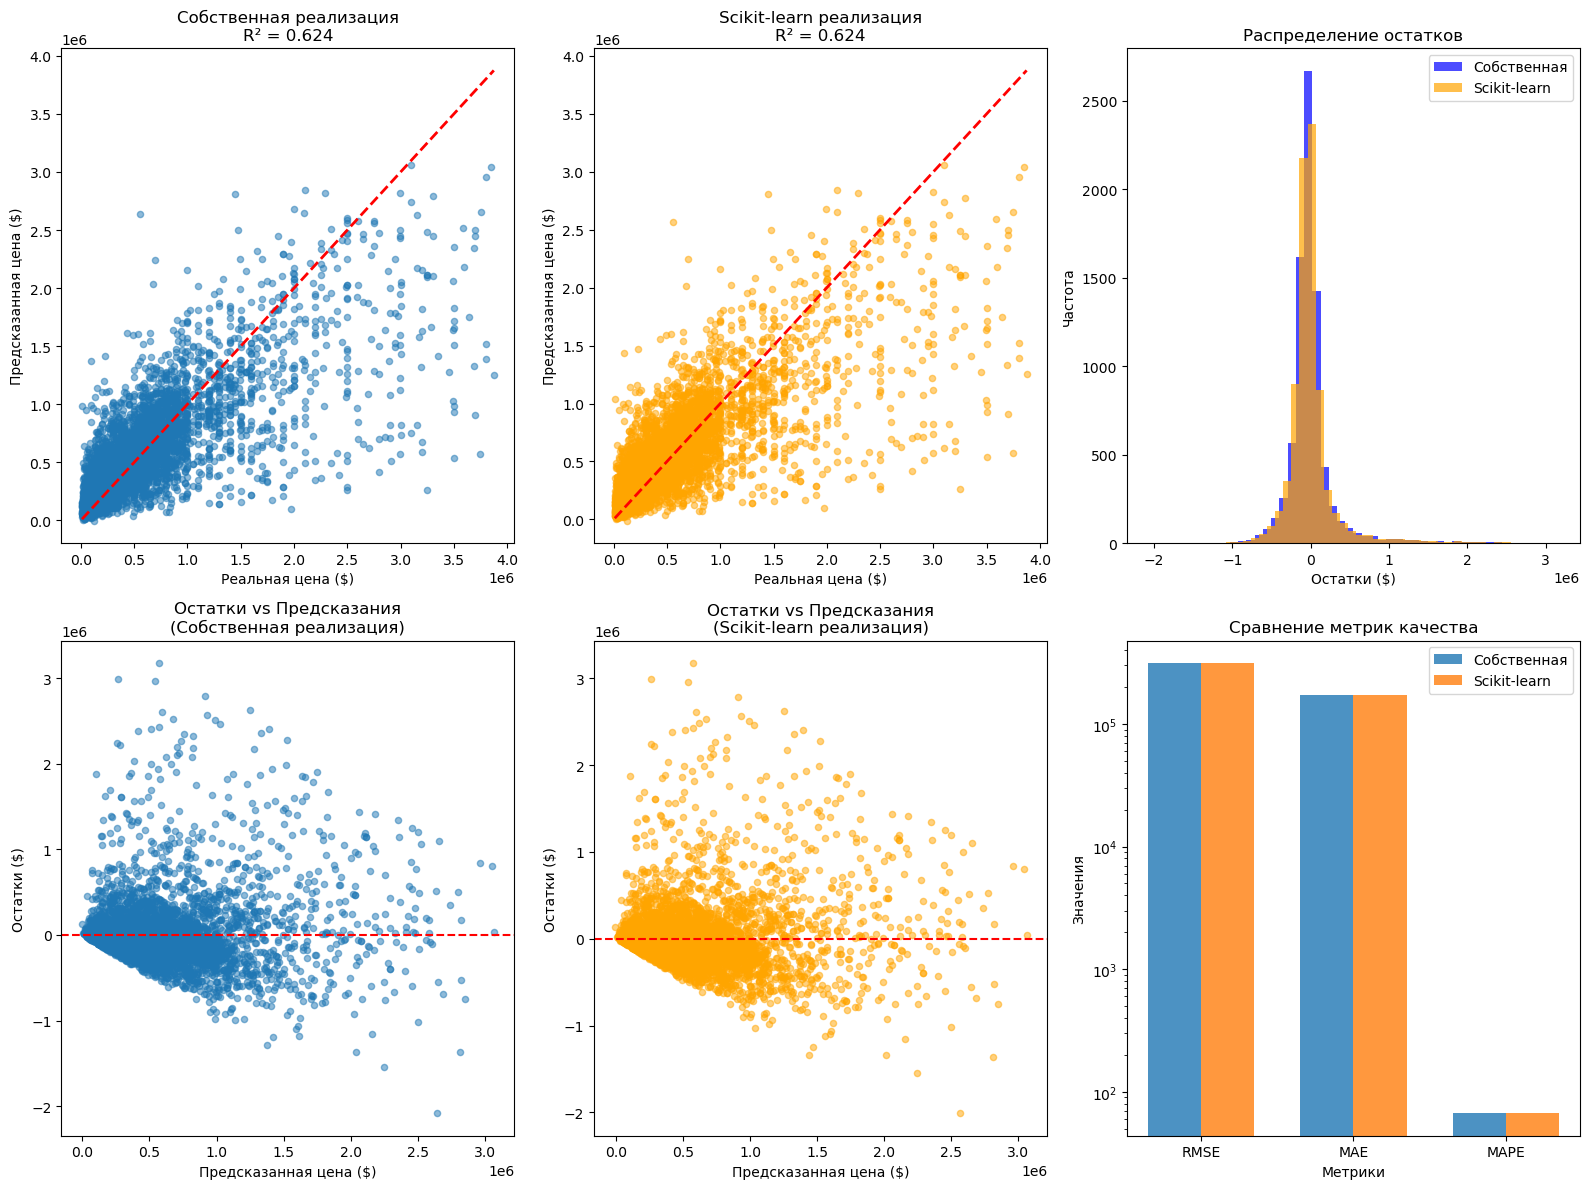

In [13]:
# Визуализация результатов прогнозирования
plt.figure(figsize=(16, 12))

plt.subplot(2, 3, 1)
plt.scatter(y_test, custom_pred, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Реальная цена ($)')
plt.ylabel('Предсказанная цена ($)')
plt.title(f'Собственная реализация\nR² = {custom_metrics["R2"]:.3f}')
plt.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))

plt.subplot(2, 3, 2)
plt.scatter(y_test, sklearn_pred, alpha=0.5, s=20, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Реальная цена ($)')
plt.ylabel('Предсказанная цена ($)')
plt.title(f'Scikit-learn реализация\nR² = {sklearn_metrics["R2"]:.3f}')
plt.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))

# Распределение остатков
custom_residuals = y_test - custom_pred
sklearn_residuals = y_test - sklearn_pred

plt.subplot(2, 3, 3)
plt.hist(custom_residuals, bins=50, alpha=0.7, label='Собственная', color='blue')
plt.hist(sklearn_residuals, bins=50, alpha=0.7, label='Scikit-learn', color='orange')
plt.xlabel('Остатки ($)')
plt.ylabel('Частота')
plt.title('Распределение остатков')
plt.legend()
plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Остатки vs предсказанные значения
plt.subplot(2, 3, 4)
plt.scatter(custom_pred, custom_residuals, alpha=0.5, s=20)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанная цена ($)')
plt.ylabel('Остатки ($)')
plt.title('Остатки vs Предсказания\n(Собственная реализация)')
plt.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))

plt.subplot(2, 3, 5)
plt.scatter(sklearn_pred, sklearn_residuals, alpha=0.5, s=20, color='orange')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанная цена ($)')
plt.ylabel('Остатки ($)')
plt.title('Остатки vs Предсказания\n(Scikit-learn реализация)')
plt.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))

# Сравнение метрик
plt.subplot(2, 3, 6)
metrics_names = ['RMSE', 'MAE', 'MAPE']
custom_values = [custom_metrics['RMSE'], custom_metrics['MAE'], custom_metrics['MAPE']]
sklearn_values = [sklearn_metrics['RMSE'], sklearn_metrics['MAE'], sklearn_metrics['MAPE']]

x = np.arange(len(metrics_names))
width = 0.35

plt.bar(x - width/2, custom_values, width, label='Собственная', alpha=0.8)
plt.bar(x + width/2, sklearn_values, width, label='Scikit-learn', alpha=0.8)

plt.xlabel('Метрики')
plt.ylabel('Значения')
plt.title('Сравнение метрик качества')
plt.xticks(x, metrics_names)
plt.legend()
plt.yscale('log')

plt.tight_layout()
plt.show()

## Анализ важности признаков

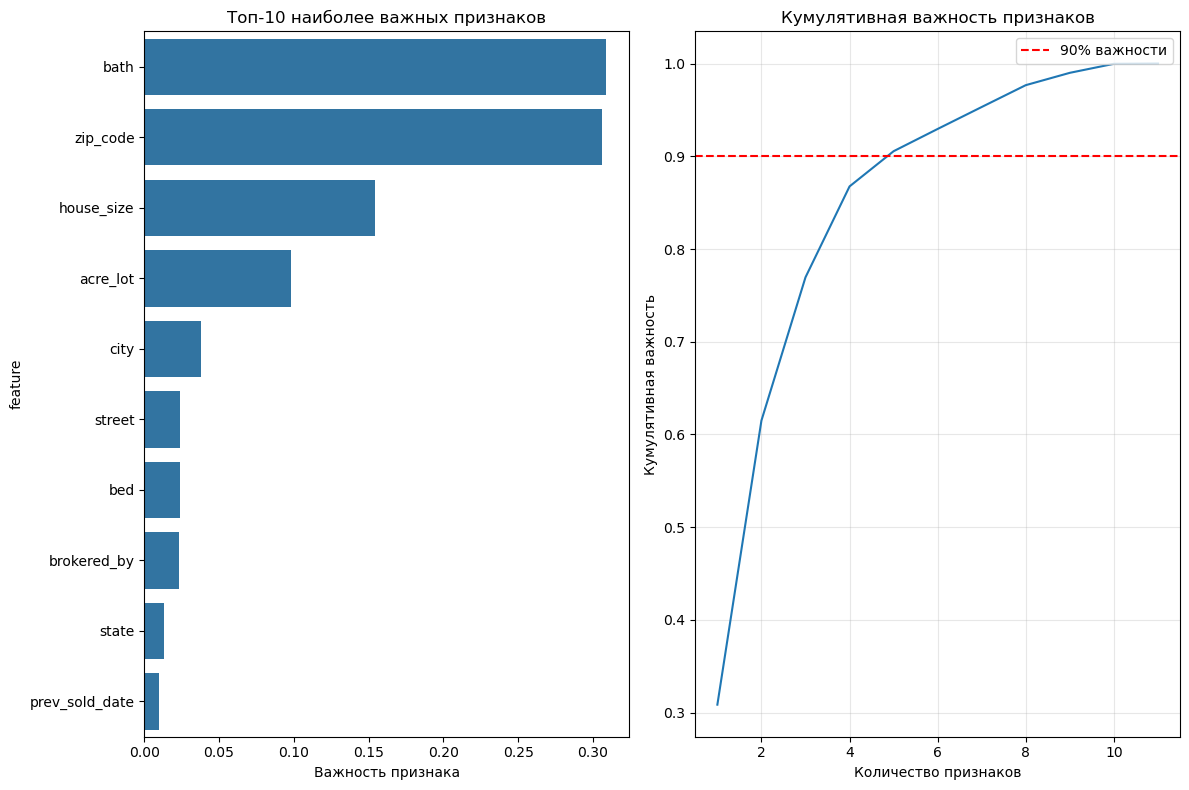


Топ-10 наиболее важных признаков:
 1. bath           : 0.3086
 2. zip_code       : 0.3064
 3. house_size     : 0.1545
 4. acre_lot       : 0.0980
 5. city           : 0.0380
 6. street         : 0.0240
 7. bed            : 0.0237
 8. brokered_by    : 0.0235
 9. state          : 0.0133
10. prev_sold_date : 0.0097

Для достижения 90% важности нужно 7 признаков из 11


In [16]:
# Анализ важности признаков (только для sklearn модели)
if hasattr(sklearn_gb, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': sklearn_gb.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    
    # Топ-10 наиболее важных признаков
    top_features = feature_importance.head(10)
    
    plt.subplot(1, 2, 1)
    sns.barplot(data=top_features, y='feature', x='importance')
    plt.title('Топ-10 наиболее важных признаков')
    plt.xlabel('Важность признака')
    
    # Кумулятивная важность признаков
    plt.subplot(1, 2, 2)
    cumulative_importance = feature_importance['importance'].cumsum()
    plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance)
    plt.axhline(y=0.9, color='r', linestyle='--', label='90% важности')
    plt.xlabel('Количество признаков')
    plt.ylabel('Кумулятивная важность')
    plt.title('Кумулятивная важность признаков')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nТоп-10 наиболее важных признаков:")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"{i:2d}. {row['feature']:15s}: {row['importance']:.4f}")
    
# Количество признаков для 90% важности
    features_90_pct = (cumulative_importance >= 0.9).idxmax() + 1
    print(f"\nДля достижения 90% важности нужно {features_90_pct} признаков из {len(feature_importance)}")
